In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import numpy as np
import pandas as pd

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import get_covid19india_api_data
from data.processing import get_data
from models.ihme.dataloader import get_dataframes_cached

from models.seir.seir_testing import SEIR_Testing
from models.seir.seirhd import SEIRHD
from models.seir.seir_movement import SEIR_Movement
from models.seir.seir_movement_testing import SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report

## Load Covid19india Data

In [91]:
# dataframes = get_covid19india_api_data()
dataframes = get_dataframes_cached()

../../cache/dataframes_ts_03062020.pkl


In [92]:
predictions_dict = {}

## Select Districts to fit on

In [93]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

Performing m1 fit ..
fetching from athenadb...
6191
len truncated 33
39.580976863753214
389.0
2020-05-02 00:00:00 0.04207611633547184
53.27681660899654
289.0
2020-05-03 00:00:00 0.03767914656194223
61.09920634920635
252.0
2020-05-04 00:00:00 0.07928634416729705
38.97974683544304
395.0
2020-05-05 00:00:00 0.0815189873417722
49.82847896440129
309.0
2020-05-06 00:00:00 0.03970423435029068
32.21129707112971
478.0
2020-05-07 00:00:00 0.013453896115264279
43.128851540616246
357.0
2020-05-08 00:00:00 0.06603425683999108
54.79359430604982
281.0
2020-05-09 00:00:00 0.19258874634313267
47.52160493827161
324.0
2020-05-10 00:00:00 0.040714067977441266
38.97974683544304
395.0
2020-05-11 00:00:00 0.0815189873417722
39.17811704834605
393.0
2020-05-12 00:00:00 0.002181950028813379
32.41473684210526
475.0
2020-05-13 00:00:00 0.06778947368421047
36.92326139088729
417.0
2020-05-14 00:00:00 0.059509227150653383
20.501997336884155
751.0
2020-05-15 00:00:00 0.026496406921263913
28.148080438756857
547.0
2020

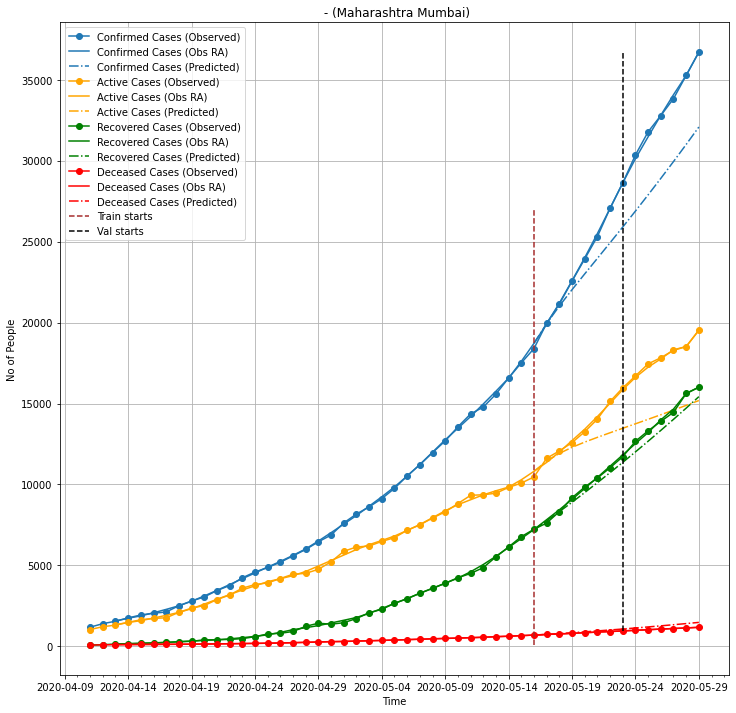

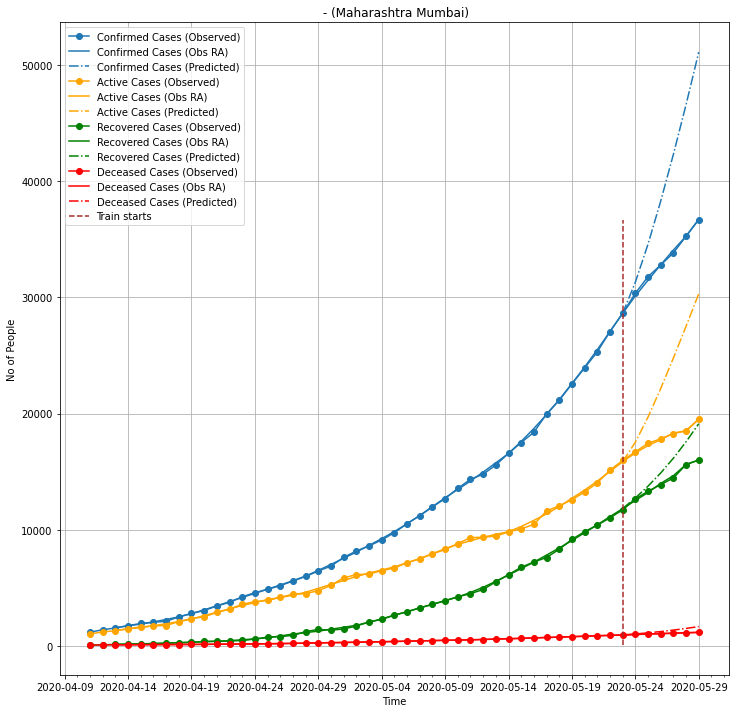

In [155]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=7, num_evals=5,
        data_from_tracker=False, initialisation='intermediate', model=SEIR_Testing, 
        smooth_jump=True, smoothing_method='weighted', smoothing_length=33,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(
        dataframes, state, district, train_period=7, val_period=0, num_evals=5,
        data_from_tracker=False, initialisation='intermediate', model=SEIR_Testing, 
        smooth_jump=True, smoothing_method='weighted', smoothing_length=33,
        which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [95]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                   hospitalised total_infected deceased recovered   
Maharashtra Mumbai        17.93           8.17     1.18       3.5   

                            val                                    
                   hospitalised total_infected deceased recovered  
Maharashtra Mumbai        41.39          19.48     1.69     15.41

### M2 Loss

In [96]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         6.52           0.52    17.62     12.04

## Plot Forecasts

getting forecasts ..


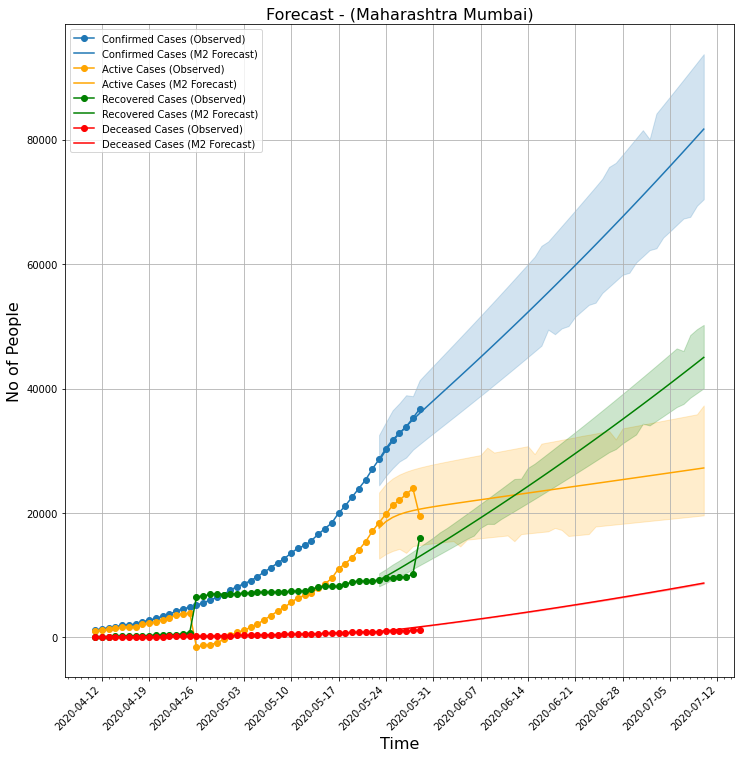

In [97]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create Report (v1)

In [98]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [99]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [100]:
write_csv(df_output)

In [101]:
## Produce Top 10 Trials / Plots

In [102]:
m = 'm2'

In [103]:
params_array = []
for trial in predictions_dict[(state, district)][m]['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)
params_array = np.array(params_array)

In [104]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)][m]['trials']])
least_losses_indices = np.argsort(losses_array)
top10losses = losses_array[least_losses_indices][:10]

In [105]:
top10params = params_array[least_losses_indices[:10]]

In [106]:
top10predictions = [get_forecast(predictions_dict[('Maharashtra', 'Mumbai')],
                                  best_params=params_dict) for params_dict in top10params]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_trials(m_dict, top10losses, top10params, top10predictions):
    df_true = m_dict['df_district']
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['total_infected'],
            '-o', color='C0', label='Confirmed Cases (Observed)')
    for i, df_prediction in enumerate(top10predictions):
        loss_value = np.around(np.sort(top10losses)[:10][i], 2)
        sns.lineplot(x="date", y="total_infected", data=df_prediction,
                    ls='-', label='Confirmed Cases ({})'.format(loss_value))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1], s=loss_value)
        
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    plt.yscale('log')
    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    return ax

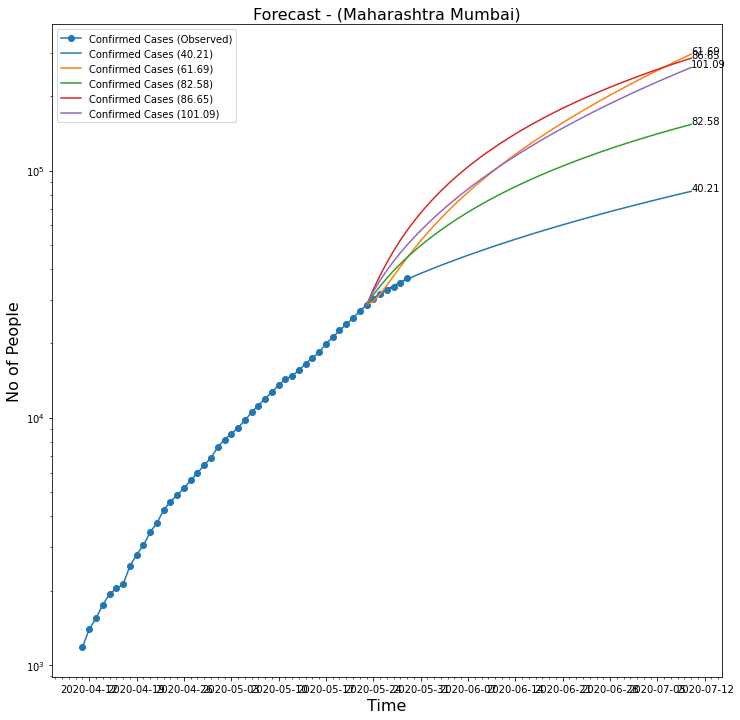

In [108]:
for region in predictions_dict.keys():
    predictions_dict[region][m]['top10params'] = top10params
    predictions_dict[region][m]['forecast_top10'] = plot_trials(predictions_dict[region][m], top10losses, top10params, top10predictions)

In [109]:
import time
for region in predictions_dict.keys():
    t = time.time()
    create_report(predictions_dict[region], ROOT_DIR=f'../../reports/{t}')

In [110]:
from main.seir.fitting import get_regional_data 

orig_df_district, _ = get_regional_data(dataframes, 'Maharashtra', 'Mumbai', data_from_tracker=False, data_format='new', filename=None)

fetching from athenadb...


In [111]:
dataframes
state='Maharashtra'
district='Mumbai'
data_from_tracker=False
smooth_jump=True
smoothing_length=28
smoothing_method='weighted'
filename=None
data_format='new'

if data_from_tracker:
    main_df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
else:
    main_df_district = get_data(state=state, district=district, disable_tracker=True, filename=filename, 
                            data_format=data_format)

df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')


fetching from athenadb...


In [153]:
df_district=copy.copy(main_df_district)
if smooth_jump:
    if data_from_tracker:
        d1, d2 = '2020-05-29', '2020-05-30'
    else:
        d1, d2 = '2020-05-28', '2020-05-29'
    df_district = df_district.set_index('date')
    big_jump = df_district.loc[d2, 'recovered'] - df_district.loc[d1, 'recovered']
    print(big_jump)
    if smoothing_method == 'linear':
        for i, day_number in enumerate(range(smoothing_length-2, -1, -1)):
            date = datetime.datetime.strptime(d1, '%Y-%m-%d') - datetime.timedelta(days=day_number)
            offset = np.random.binomial(1, (big_jump%smoothing_length)/smoothing_length)
            df_district.loc[date, 'recovered'] += ((i+1)*big_jump)//smoothing_length + offset
            df_district.loc[date, 'hospitalised'] -= ((i+1)*big_jump)//smoothing_length + offset

    elif smoothing_method == 'weighted':
        newcases = df_district['total_infected'].shift(14) - df_district['total_infected'].shift(15)
        idx = newcases.first_valid_index()
        newcases = newcases.loc[idx:d1]
        truncated = df_district.loc[idx:d1, :]
        invpercent = newcases.sum()/newcases
        runningsum = 0
        for i, day_number in enumerate(range(smoothing_length-2, -1, -1)):
            date = datetime.datetime.strptime(d1, '%Y-%m-%d') - datetime.timedelta(days=day_number)
            print (date, (big_jump%invpercent.loc[date])/newcases.loc[date])
            offset = np.random.binomial(1, (big_jump%invpercent.loc[date])/newcases.loc[date])
            runningsum += (big_jump // invpercent.loc[date]) + offset
            truncated.loc[date:, 'recovered'] += (big_jump // invpercent.loc[date]) + offset
            truncated.loc[date:, 'hospitalised'] -= (big_jump // invpercent.loc[date]) + offset
            print(date, runningsum)
        print(truncated.index)
        df_district.loc[truncated.index, 'recovered'] = truncated['recovered'].astype('int64')
        df_district.loc[truncated.index, 'hospitalised'] = truncated['hospitalised'].astype('int64')

    assert((df_district['total_infected'] == df_district['hospitalised'] + df_district['deceased'] + df_district['recovered']).all())

6191
2020-05-02 00:00:00 0.04207611633547184
2020-05-02 00:00:00 156.0
2020-05-03 00:00:00 0.03767914656194223
2020-05-03 00:00:00 272.0
2020-05-04 00:00:00 0.07928634416729705
2020-05-04 00:00:00 373.0
2020-05-05 00:00:00 0.0815189873417722
2020-05-05 00:00:00 531.0
2020-05-06 00:00:00 0.03970423435029068
2020-05-06 00:00:00 655.0
2020-05-07 00:00:00 0.013453896115264279
2020-05-07 00:00:00 847.0
2020-05-08 00:00:00 0.06603425683999108
2020-05-08 00:00:00 990.0
2020-05-09 00:00:00 0.19258874634313267
2020-05-09 00:00:00 1102.0
2020-05-10 00:00:00 0.040714067977441266
2020-05-10 00:00:00 1232.0
2020-05-11 00:00:00 0.0815189873417722
2020-05-11 00:00:00 1390.0
2020-05-12 00:00:00 0.002181950028813379
2020-05-12 00:00:00 1548.0
2020-05-13 00:00:00 0.06778947368421047
2020-05-13 00:00:00 1738.0
2020-05-14 00:00:00 0.059509227150653383
2020-05-14 00:00:00 1905.0
2020-05-15 00:00:00 0.026496406921263913
2020-05-15 00:00:00 2206.0
2020-05-16 00:00:00 0.04857474206992386
2020-05-16 00:00:00 2

In [151]:
new = df_district
orig = main_df_district.set_index('date')
# print(pd.concat([new['hospitalised'],orig['hospitalised']], axis=1))
print(pd.concat([new['recovered'],orig['recovered']], axis=1))

recovered  recovered
date                            
2020-04-11         71         71
2020-04-12         97         97
2020-04-13        141        141
2020-04-14        164        164
2020-04-15        181        181
2020-04-16        202        202
2020-04-17        239        239
2020-04-18        281        281
2020-04-19        310        310
2020-04-20        394        394
2020-04-21        408        408
2020-04-22        425        425
2020-04-23        473        473
2020-04-24        595        595
2020-04-25        762        762
2020-04-26        802        802
2020-04-27        915        915
2020-04-28       1234       1234
2020-04-29       1427       1427
2020-04-30       1364       1364
2020-05-01       1459       1459
2020-05-02       1715       1559
2020-05-03       2076       1804
2020-05-04       2281       1908
2020-05-05       2659       2128
2020-05-06       2942       2287
2020-05-07       3282       2435
2020-05-08       3579       2589
2020-05-09       3894 

In [134]:
# df_district[44:][-10:]
compare_cols = ['total_infected','hospitalised','deceased','recovered']
# compare = (orig[compare_cols][-20:], new[compare_cols][-20:])
# compare = (new[compare_cols][-20:])
compare = (orig[compare_cols] - new[compare_cols])[-20:]
print (compare)# df_district[44:][-10:]

total_infected  hospitalised  deceased  recovered
29             NaN           NaN       NaN        NaN
30             NaN           NaN       NaN        NaN
31             NaN           NaN       NaN        NaN
32             NaN           NaN       NaN        NaN
33             NaN           NaN       NaN        NaN
34             NaN           NaN       NaN        NaN
35             NaN           NaN       NaN        NaN
36             NaN           NaN       NaN        NaN
37             NaN           NaN       NaN        NaN
38             NaN           NaN       NaN        NaN
39             NaN           NaN       NaN        NaN
40             NaN           NaN       NaN        NaN
41             NaN           NaN       NaN        NaN
42             NaN           NaN       NaN        NaN
43             NaN           NaN       NaN        NaN
44             NaN           NaN       NaN        NaN
45             NaN           NaN       NaN        NaN
46             NaN           NaN

In [71]:
ti_check = copy.copy(orig['total_infected'])
ti_check2 = copy.copy(new['total_infected'])
for col in ['hospitalised', 'recovered', 'deceased']:
    ti_check -= new[col]
    ti_check2 -= new[col]
print(pd.concat([ti_check[-25:], ti_check2[-25:]], axis=1))

total_infected  total_infected
24               0               0
25               0               0
26               0               0
27               0               0
28               0               0
29               0               0
30               0               0
31               0               0
32               0               0
33               0               0
34               0               0
35               0               0
36               0               0
37               0               0
38               0               0
39               0               0
40               0               0
41               0               0
42               0               0
43               0               0
44               0               0
45               0               0
46               0               0
47               0               0
48               0               0
